In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa import stattools
import statsmodels.api as sm

import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

In [2]:
# data_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/Data/final_data.csv"
data_path = "final_data.csv"
data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      27552 non-null  int64  
 1   datetime                        27552 non-null  object 
 2   Demand (MW)                     27552 non-null  float64
 3   Temperature                     27552 non-null  float64
 4   dewpoint                        27552 non-null  float64
 5   humidity                        27552 non-null  float64
 6   precipitation                   27552 non-null  float64
 7   precipprob                      27552 non-null  float64
 8   snow                            27552 non-null  float64
 9   snowdepth                       27552 non-null  float64
 10  windgust                        27552 non-null  float64
 11  windspeed                       27552 non-null  float64
 12  sealevelpressure                

In [4]:
def min_max_normalize_dataframe(df, columns):
    df_normalized = df.copy()
    for column in columns:
        if df[column].dtype in [int, float]:
            min_val = df[column].min()
            max_val = df[column].max()
            df_normalized[column] = (df[column] - min_val) / (max_val - min_val)
    return df_normalized

data_df.drop(columns=["Unnamed: 0", "datetime"], inplace=True)
features_columns = list(data_df.columns)
features_columns.remove('Demand (MW)')# removing the Demand (MW)

normalized_df = min_max_normalize_dataframe(data_df, columns = features_columns)
transformed_df = normalized_df[features_columns].apply(np.log1p)

transformed_df["Demand (MW)"] = data_df["Demand (MW)"]
transformed_df.head()

,Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windgust,windspeed,sealevelpressure,...,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow,Demand (MW)
0,0.349596,0.383234,0.491779,0.0,0.0,0.0,0.0,0.23543,0.116613,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,445.8
1,0.349596,0.389739,0.510850,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,424.5
2,0.349596,0.396202,0.530131,0.0,0.0,0.0,0.0,0.23543,0.085695,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,423.5
3,0.343529,0.389739,0.529492,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,418.8
4,0.329914,0.383234,0.553636,0.0,0.0,0.0,0.0,0.23543,0.085695,0.385098,...,0.0,0.0,0.693147,0.0,0.0,0.000000,0.000000,0.0,0.0,414.8


# Demand ACF and PACF Plot

In [5]:
def check_data_stationarity(X):
  """
    Check if the given series is stationarity time series data or not

    Args:
      X : Time-series data
  """
  # ADF test
  p_threshold = 0.05
  p_val = stattools.adfuller(X)[1]

  if p_val < p_threshold:
    print("Given series is stationarity data")
  else:
    print("Given series is not a stationarity data")

In [6]:
def plot_acf_pacf_graphs(X=None, lags=48):
    """ Plot the PACF and ACF graphs for the time series data X

    Args:
        X (np.array): Time-series data
    """
    fig = plt.figure(figsize=(9, 5))
    fig.subplots_adjust(hspace=0.5)

    # ACF plot
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(X, ax=ax1, lags=lags)

    # PACF plot
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(X, ax=ax2, lags=lags)
    plt.show()

In [7]:
demand_data = transformed_df["Demand (MW)"]
demand_data

0        445.8
1        424.5
2        423.5
3        418.8
4        414.8
         ...  
27547    498.7
27548    498.8
27549    506.4
27550    478.8
27551    457.7
Name: Demand (MW), Length: 27552, dtype: float64

In [8]:
print(demand_data.iloc[-7344:].isnull().sum())
demand_data = demand_data.dropna()

0


In [9]:
check_data_stationarity(demand_data)

Given series is stationarity data


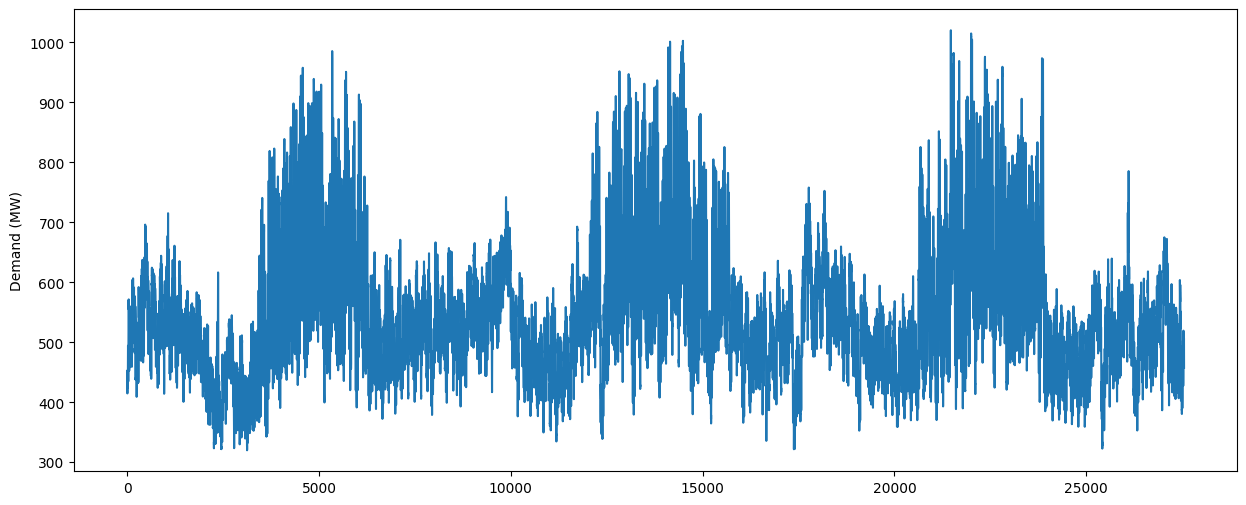

In [10]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=demand_data)
plt.show()

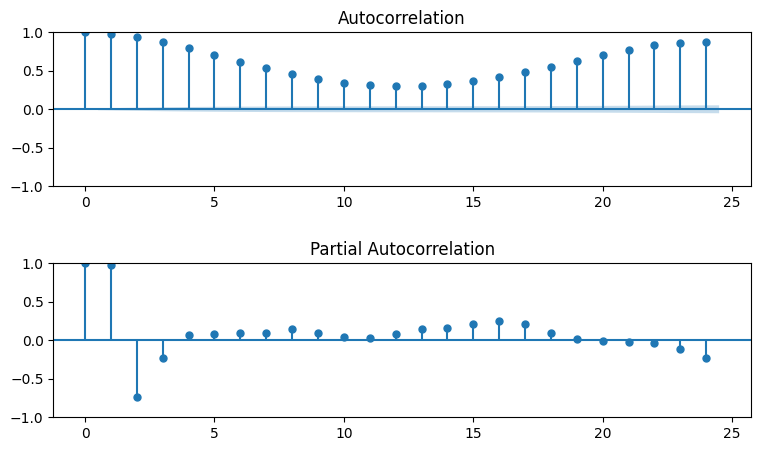

In [11]:
plot_acf_pacf_graphs(X=demand_data, lags=24)

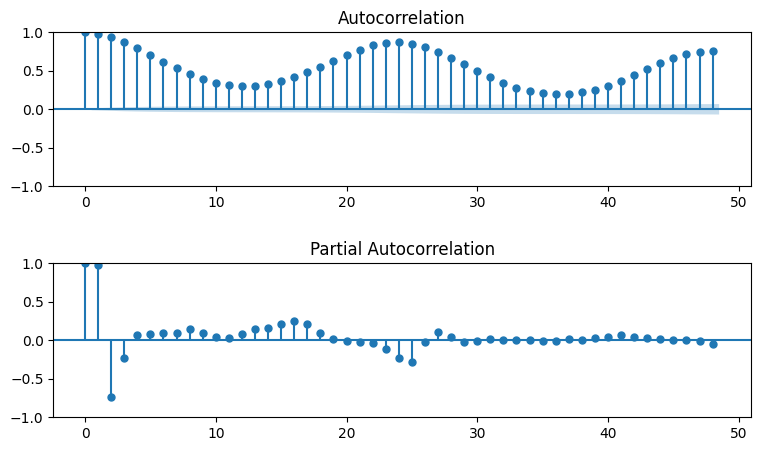

In [12]:
plot_acf_pacf_graphs(X=demand_data, lags=48)

# SARIMA Model

In [25]:
# !pip install pmdarima

In [13]:
import warnings
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.sm_exceptions import  ValueWarning
warnings.simplefilter('ignore', ValueWarning)

import time

/tmp/ipykernel_24872/4283295474.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

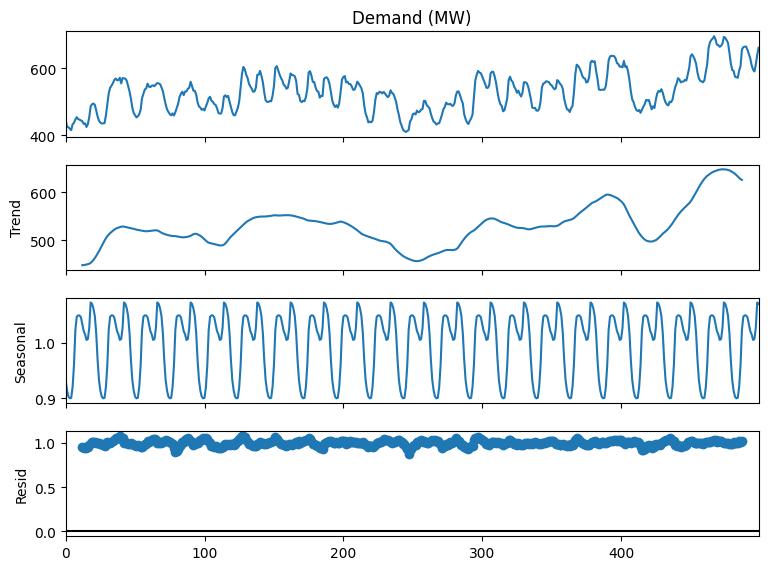

In [15]:
# # since variance of the changes with time, we are using the multiplicative model
# # With the period of 24 hours or 24 data points, the demand season is repeating again
result = seasonal_decompose(demand_data[:500], model='multiplicative', period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

/tmp/ipykernel_24872/3015802152.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

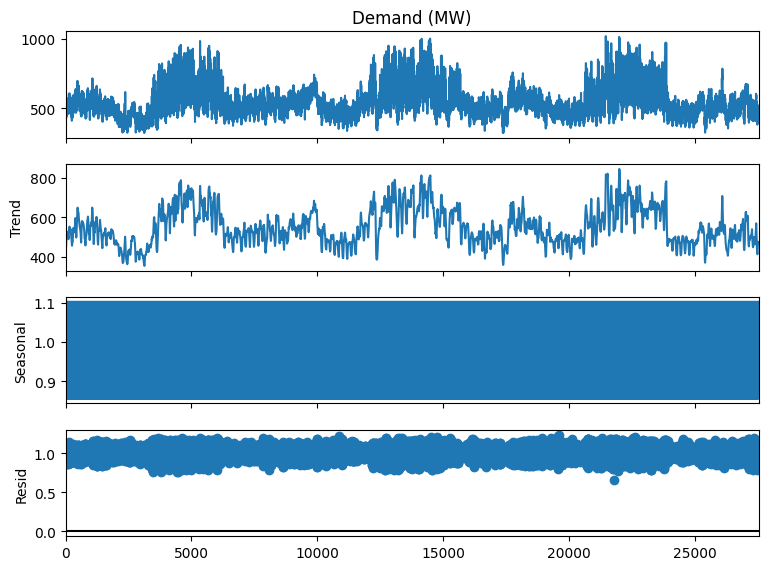

In [16]:
# since variance of the changes with time, we are using the multiplicative model
# With the period of 24 hours or 24 data points, the demand season is repeating again
result = seasonal_decompose(demand_data, model='multiplicative', period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

In time series analysis, the Akaike Information Criterion (AIC) is a measure of the relative quality of a statistical model. It is commonly used for model selection, helping to balance the trade-off between the goodness of fit of the model and its complexity. 

In [18]:
# Do not run this cell as it consumes more memory
# here m = 24 for hourly data representing the daily seasonal cycle
running_first_time = True
if running_first_time is True:
    start_time = time.time()
    auto_arima_demand_param_data = demand_data[:5000]
    model = auto_arima(auto_arima_demand_param_data, seasonal=True, m=24, suppress_warnings=True, trace=True)
    print(model.order)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time} seconds")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=38.01 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=44718.657, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=39086.680, Time=5.76 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=40970.506, Time=7.55 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=44716.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=40355.132, Time=0.23 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=18.99 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=11.62 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=39719.356, Time=5.93 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=43.24 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=5.98 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=38604.017, Time=10.74 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=40294.600, Time=0.32 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=34.08 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept 

In [19]:
m = 24
p, d, q = 2, 1, 0
sarima_model = SARIMAX(demand_data, order=(p, d, q),
                seasonal_order=(p, d, q, m))
fitted = sarima_model.fit()
print(fitted.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93852D+00    |proj g|=  3.25980D-02


 This problem is unconstrained.



At iterate    5    f=  3.92339D+00    |proj g|=  7.45721D-02

At iterate   10    f=  3.91681D+00    |proj g|=  1.42605D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   2.140D-06   3.917D+00
  F =   3.9168099267240351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                        Demand (MW)   No. Observations:                27552
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 24)   Log Likelihood             -107915.947
Date:                     

In [27]:
no_of_predictions = 7*24
previous_data_start = 27200

predictions = fitted.predict(len(demand_data), len(demand_data)+no_of_predictions)

# Assuming demand_data and predictions are pandas DataFrames
demand_data_subset = demand_data.iloc[previous_data_start:]

print(demand_data_subset.shape, predictions.shape)

(352,) (169,)


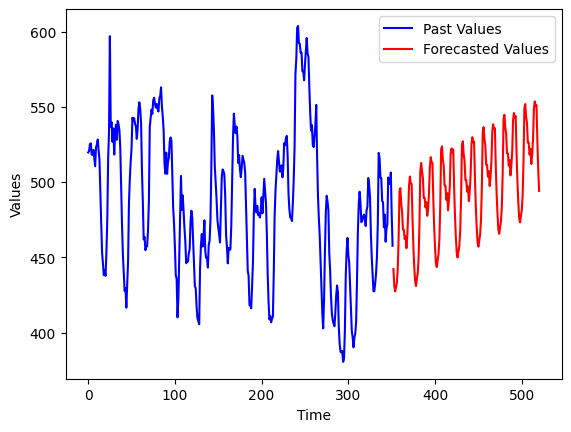

In [28]:
past_values = demand_data_subset
forecasted_values = predictions
plt.plot(range(len(past_values)), past_values, color='blue', label='Past Values')

# Plotting the forecasted values in red, starting after the past values
plt.plot(range(len(past_values), len(past_values) + len(forecasted_values)), forecasted_values, color='red', label='Forecasted Values')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Display the plot
plt.show()

In [16]:
fitted.save('Model Archive/sarima_model_1.pkl')

In [17]:
loaded_model = sm.load('Model Archive/sarima_model_1.pkl')


KeyboardInterrupt

